In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pandas as pd
# from indicators import *
import mplfinance as mpf
from sklearn import preprocessing

from ta.trend import SMAIndicator, macd, PSARIndicator
from ta.volatility import BollingerBands
from ta.momentum import rsi
from ta.volume import acc_dist_index, ease_of_movement, force_index
from utils import *
# from main_func import *
from ta import add_all_ta_features, add_trend_ta, add_volume_ta, add_volatility_ta, add_momentum_ta, add_others_ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.warn('my warning')
pd.options.mode.chained_assignment = None

<ipython-input-6-f7a44fdd84c2>:21: UserWarning: my warning
  warnings.warn('my warning')


In [7]:
def plot_rawdf(raw_df):
    plt.figure(figsize=(18,4))
    plt.grid(True)
    plt.plot(raw_df)
    plt.show()

def plot_rawdata(rawdata, ratio=0.1):
    mpf.plot(rawdata[:int(len(rawdata)*ratio)], type='candle',style='charles',figratio=(18,6),mav=(20,40), volume=True)


### load data

In [8]:
def preprocess_volume(volume):
    volume = list(volume)
    for i in range(len(volume)):
        if volume[i] == 0:
            volume[i] = volume[i-1]
    return np.array(volume)


raw_df = pd.read_csv('./ETHUSDT_1h.csv', index_col=False)
raw_df.reset_index(drop=True, inplace=True)
raw_df = raw_df.rename({'Volume ETH': 'Volume'}, axis=1)
raw_df['Volume'] = preprocess_volume(raw_df['Volume'])
raw_df['Volume USDT'] = preprocess_volume(raw_df['Volume USDT'])
raw_df['tradecount'] = preprocess_volume(raw_df['tradecount'])
# raw_df.loc[-1] = np.zeros(len(raw_df.columns))  # [0 for i in range(len(raw_df.columns))]  # adding a row
# raw_df.index = raw_df.index + 1  # shifting index
# df = raw_df.sort_values('Unix')
eth_df = raw_df.iloc[::-1]
# df.set_index('Date')
# df = raw_df.reindex(index=raw_df.index[::-1])
print(eth_df.columns)
print(eth_df.head)

Index(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Volume USDT', 'tradecount'],
      dtype='object')
<bound method NDFrame.head of                 Unix                 Date   Symbol     Open     High      Low  \
48445  1502942400000  2017-08-17 04:00:00  ETHUSDT   301.13   302.57   298.00   
48444  1502946000000  2017-08-17 05:00:00  ETHUSDT   301.61   303.28   300.00   
48443  1502949600000  2017-08-17 06:00:00  ETHUSDT   302.40   304.44   301.90   
48442  1502953200000  2017-08-17 07:00:00  ETHUSDT   302.68   307.96   302.60   
48441  1502956800000  2017-08-17 08:00:00  ETHUSDT   307.95   309.97   307.00   
...              ...                  ...      ...      ...      ...      ...   
4      1678561200000  2023-03-11 19:00:00  ETHUSDT  1448.59  1452.19  1443.87   
3      1678564800000  2023-03-11 20:00:00  ETHUSDT  1449.22  1470.00  1449.21   
2      1678568400000  2023-03-11 21:00:00  ETHUSDT  1466.20  1469.19  1457.51   
1      1678572000000  2023

#### feature engineering
https://zh.wikipedia.org/zh-hk/%E6%8C%87%E6%95%B0%E5%B9%B3%E6%BB%91%E7%A7%BB%E5%8A%A8%E5%B9%B3%E5%9D%87%E7%BA%BF

In [9]:
def AddStatIndicators(df):
    df_stat = df.copy()
    # add basic statistic indicators
    df_stat['Price Oscilliation'] = df['High'] - df['Low']
    df_stat['Avg Price ETH'] = df['Volume'] / df['tradecount']
    df_stat['Avg Price USDT'] = df['Volume USDT'] / df['tradecount']
    df_stat['USDT'] = df['Volume USDT'] / df['Volume']
    df_stat.drop(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
    print("Correlation of Statistic Indicators:")
    plot_corr(df_stat)
    return df_stat


def AddTrendIndicators(df):
    # Add Simple Moving Average (SMA) indicators
    # short period: 1,4,12h / 5, 10h
    # mid: 24, 72, 168h / 30, 60h
    # long: 7, 30, 60 days 
    # 7, 25, 99 for stocks
    # simple moving average (SMA)
    df_trend = df.copy()
    df_trend["sma5"] = SMAIndicator(close=df["Close"], window=5, fillna=True).sma_indicator()
    df_trend["sma10"] = SMAIndicator(close=df["Close"], window=10, fillna=True).sma_indicator()
    df_trend["sma24"] = SMAIndicator(close=df["Close"], window=24, fillna=True).sma_indicator()
    df_trend["sma72"] = SMAIndicator(close=df["Close"], window=72, fillna=True).sma_indicator()
    df_trend["sma168"] = SMAIndicator(close=df["Close"], window=168, fillna=True).sma_indicator()
    df_trend = add_trend_ta(df_trend, high="High", low="Low", close="Close")
    df_trend.drop(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
    print("Correlation of Trend Indicators:")
    plot_corr(df_trend)
    return df_trend


def AddBollingerBandsIndicators(df):
    # Add Bollinger Bands indicator
    df_bb = df.copy()
    indicator_bb = BollingerBands(close=df["Close"], window=24, window_dev=2)
    df_bb['bb_bbm'] = indicator_bb.bollinger_mavg()
    df_bb['bb_bbh'] = indicator_bb.bollinger_hband()
    df_bb['bb_bbl'] = indicator_bb.bollinger_lband()
    print("Correlation of Bollinger Bands Indicators:")
    df_bb.drop(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
    plot_corr(df_bb)
    return df_bb


def AddVolumeIndicators(df):
    df_vol = df.copy()
    df_vol = add_volume_ta(df_vol, high="High", low="Low", close="Close", volume="Volume")
    print("Correlation of Volume Indicators:")
    df_vol.drop(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
    plot_corr(df_vol)
    return df_vol


def AddOtherIndicators(df):
    # Add Parabolic Stop and Reverse (Parabolic SAR) indicator
    df_other = df.copy()
    indicator_psar = PSARIndicator(high=df["High"], low=df["Low"], close=df["Close"], step=0.02, max_step=2, fillna=True)
    df_other['psar'] = indicator_psar.psar()
    # Add Moving Average Convergence Divergence (MACD) indicator
    df_other["MACD"] = macd(close=df["Close"], window_slow=26, window_fast=12, fillna=True) # mazas
    # Add Relative Strength Index (RSI) indicator
    df_other["RSI"] = rsi(close=df["Close"], window=14, fillna=True) # mazas
    print("Correlation of Other Indicators:")
    df_other.drop(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
    plot_corr(df_other)
    return df_other

def AddMomentumIndicators(df):
    df_momentum = df.copy()
    df_momentum = add_momentum_ta(df_momentum, high="High", low="Low", close="Close", volume="Volume")
    print("Correlation of Momentum Indicators:")
    df_momentum.drop(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
    plot_corr(df_momentum)
    return df_momentum


def AddVolatilityIndicators(df):
    df_volatility = df.copy()
    df_volatility = add_volatility_ta(df_volatility, high="High", low="Low", close="Close")
    print("Correlation of Volatility Indicators:")
    df_volatility.drop(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
    plot_corr(df_volatility)
    return df_volatility


def AddIndicators(df_ori):

    df = df_ori.copy()
    # df_constant = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'Date', 'Symbol']]
    
    # add basic statistic indicators
    df_stat = AddStatIndicators(df)
    # add Simple Moving Average (SMA) indicators
    df_trend = AddTrendIndicators(df)
    # add momentum indicators
    df_momentum = AddMomentumIndicators(df)
    # Add Bollinger Bands indicator
    df_bb = AddBollingerBandsIndicators(df)
    # add other indicators
    df_other = AddOtherIndicators(df)
    # add volume indicators
    df_volume = AddVolumeIndicators(df)
    # add volatility indicators
    df_vol = AddVolatilityIndicators(df)

    final_df = [df, df_stat, df_trend, df_bb, df_vol, df_volume, df_momentum, df_other]
    result = pd.concat(final_df, axis=1)
    return result

def plot_corr(df):
    df_copy = df.copy()

    num_features = len(df.columns)
    fig_width = 4 + num_features if num_features <= 21 else 25
    # Plot Heatmap Correlation
    fig = plt.figure(figsize=(int(fig_width*1.2), fig_width))
    print(num_features, " features:", df_copy.columns)
    ax = sns.heatmap(df_copy.corr(), annot=True, square=True)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    fig.tight_layout()
    plt.show()
    # plt.savefig("raw_indicators.png")


def DropCorrelatedFeatures(df, threshold=0.5):
    df_copy = df.copy()

    # Remove OHCL columns
    df_drop = df_copy.drop(["Date", "Open", "High", "Low", "Close", "Volume", "Volume USDT"], axis=1)
    # Calculate Pearson correlation
    corr = df_drop.corr()
    # corr
    upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

    to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]
    print("Following features are removed because of high correlation.")
    print(to_drop)
    df_copy = df_copy.drop(to_drop, axis=1)
    print("shape of scaled dataframe", df_copy.shape)
    print("remaining features", list(df_copy.columns))
    return df_copy


Correlation of Statistic Indicators:
4  features: Index(['Price Oscilliation', 'Avg Price ETH', 'Avg Price USDT', 'USDT'], dtype='object')


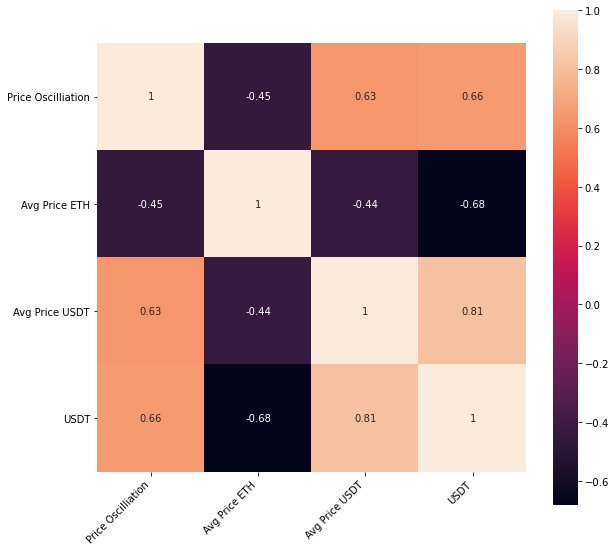

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Correlation of Trend Indicators:
39  features: Index(['sma5', 'sma10', 'sma24', 'sma72', 'sma168', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator'],
      dtype='object')


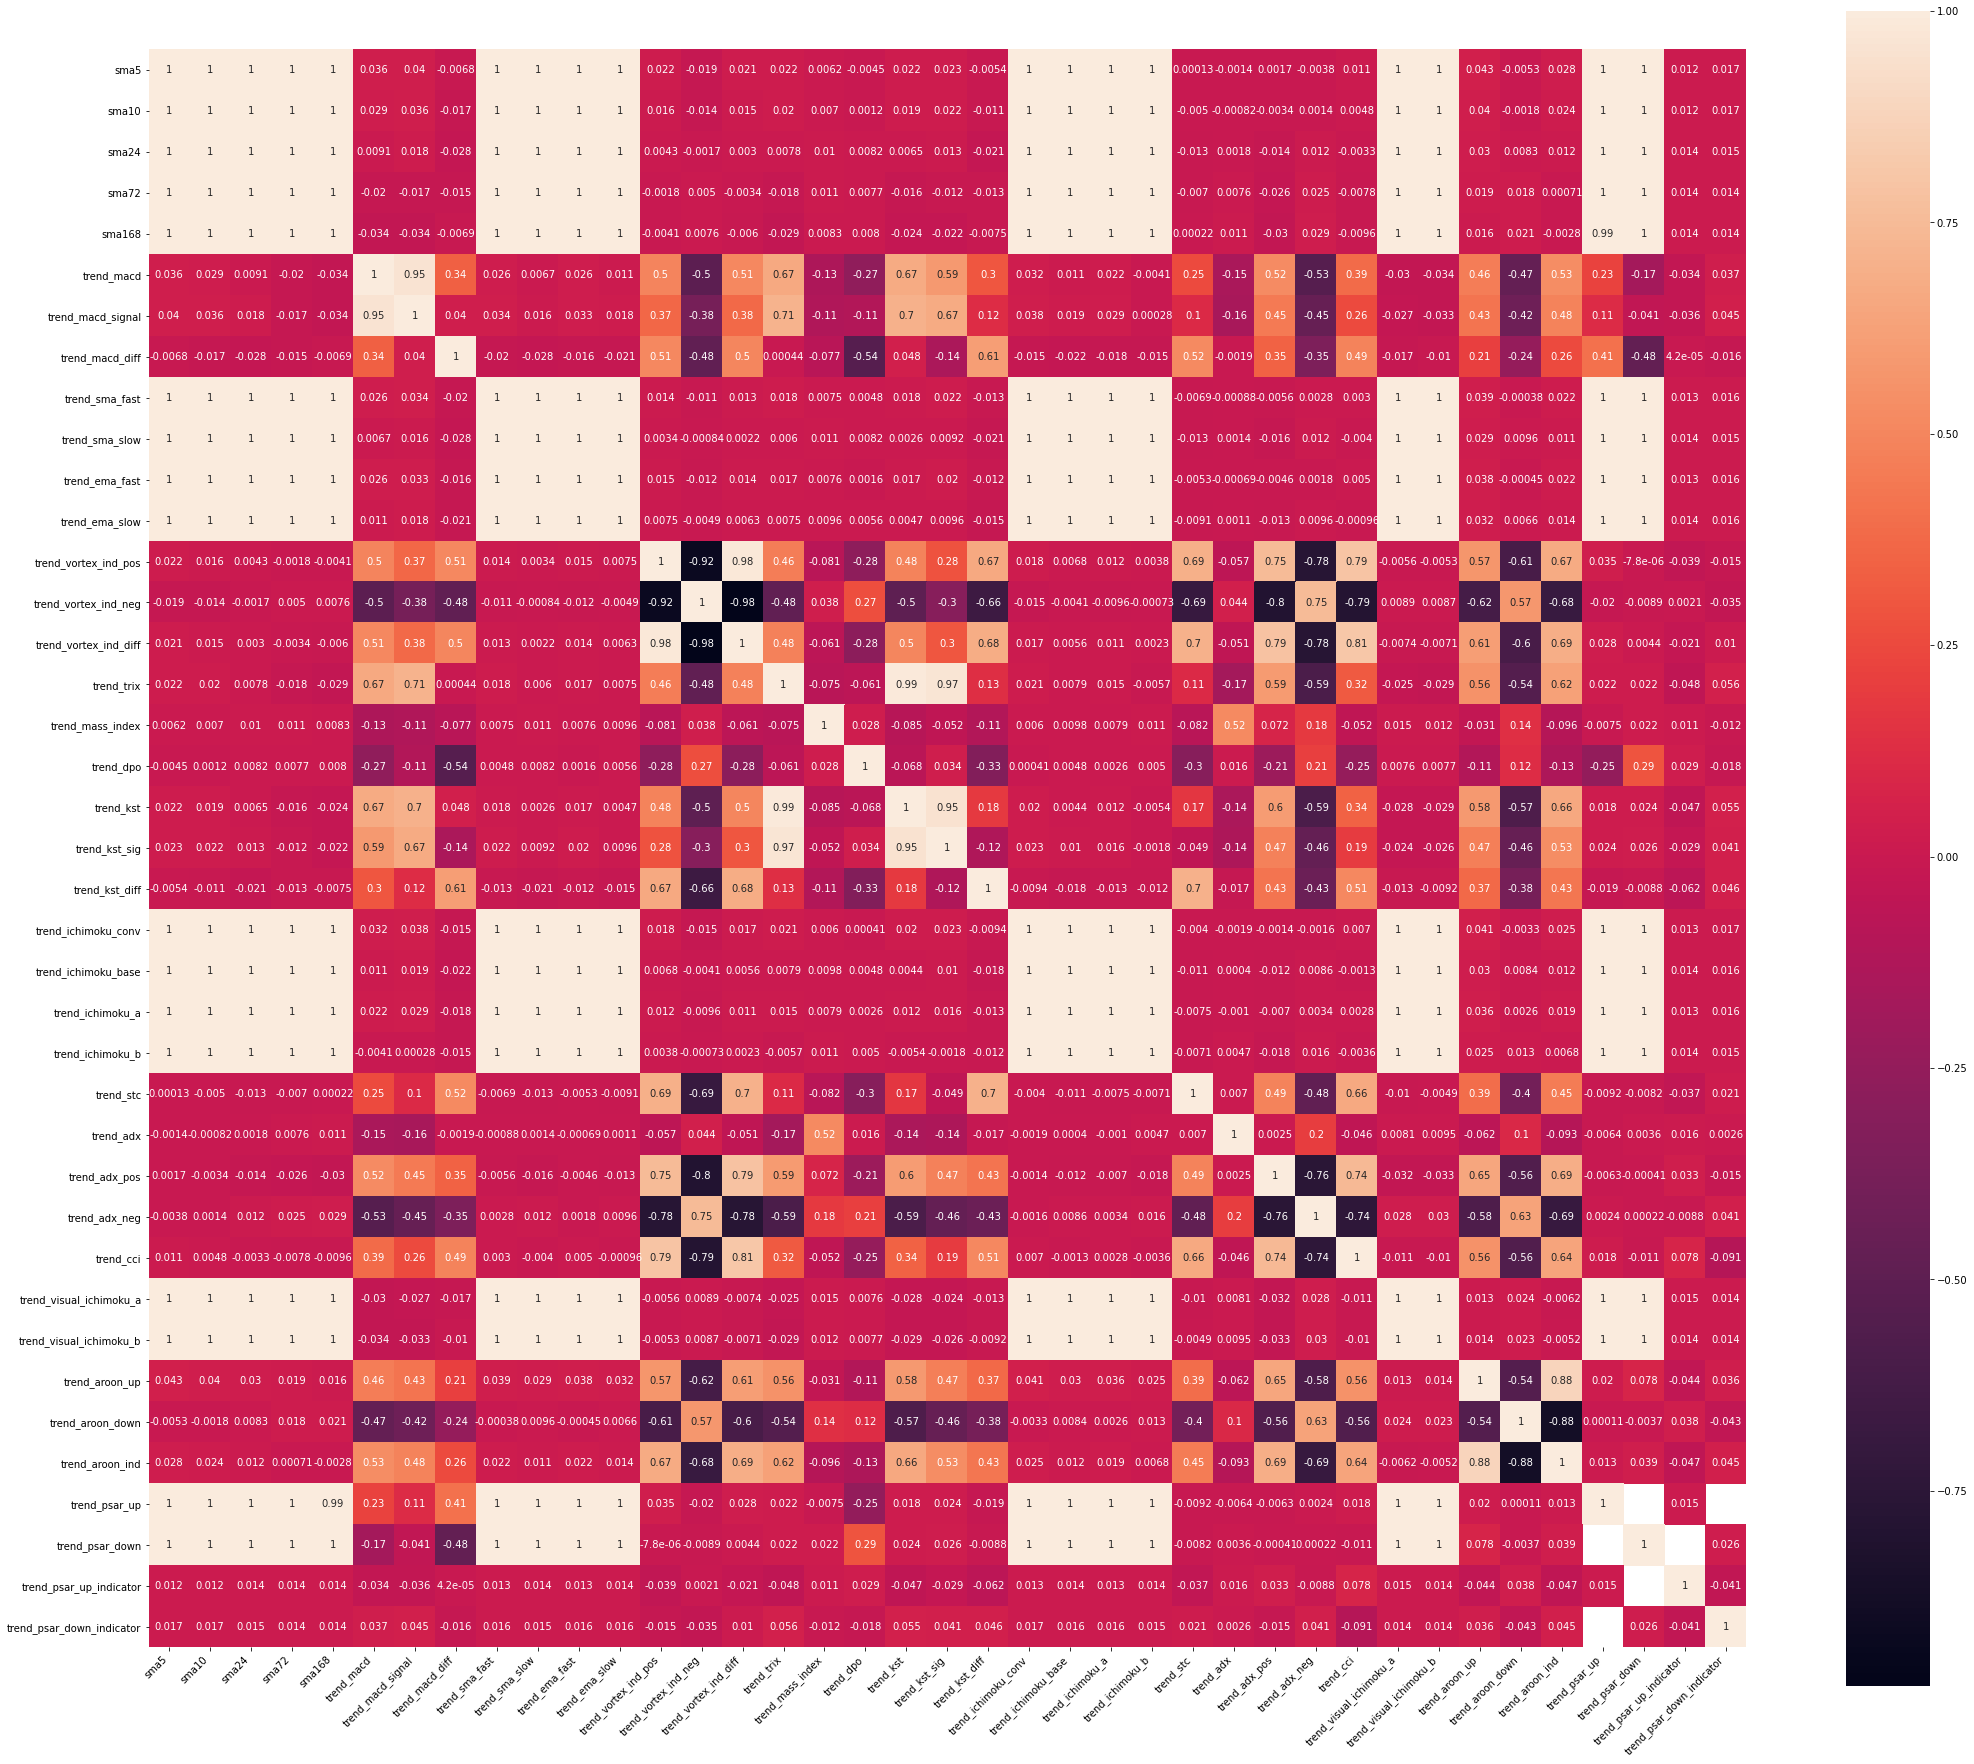

Correlation of Momentum Indicators:
18  features: Index(['momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
       'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_roc',
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist',
       'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist',
       'momentum_kama'],
      dtype='object')


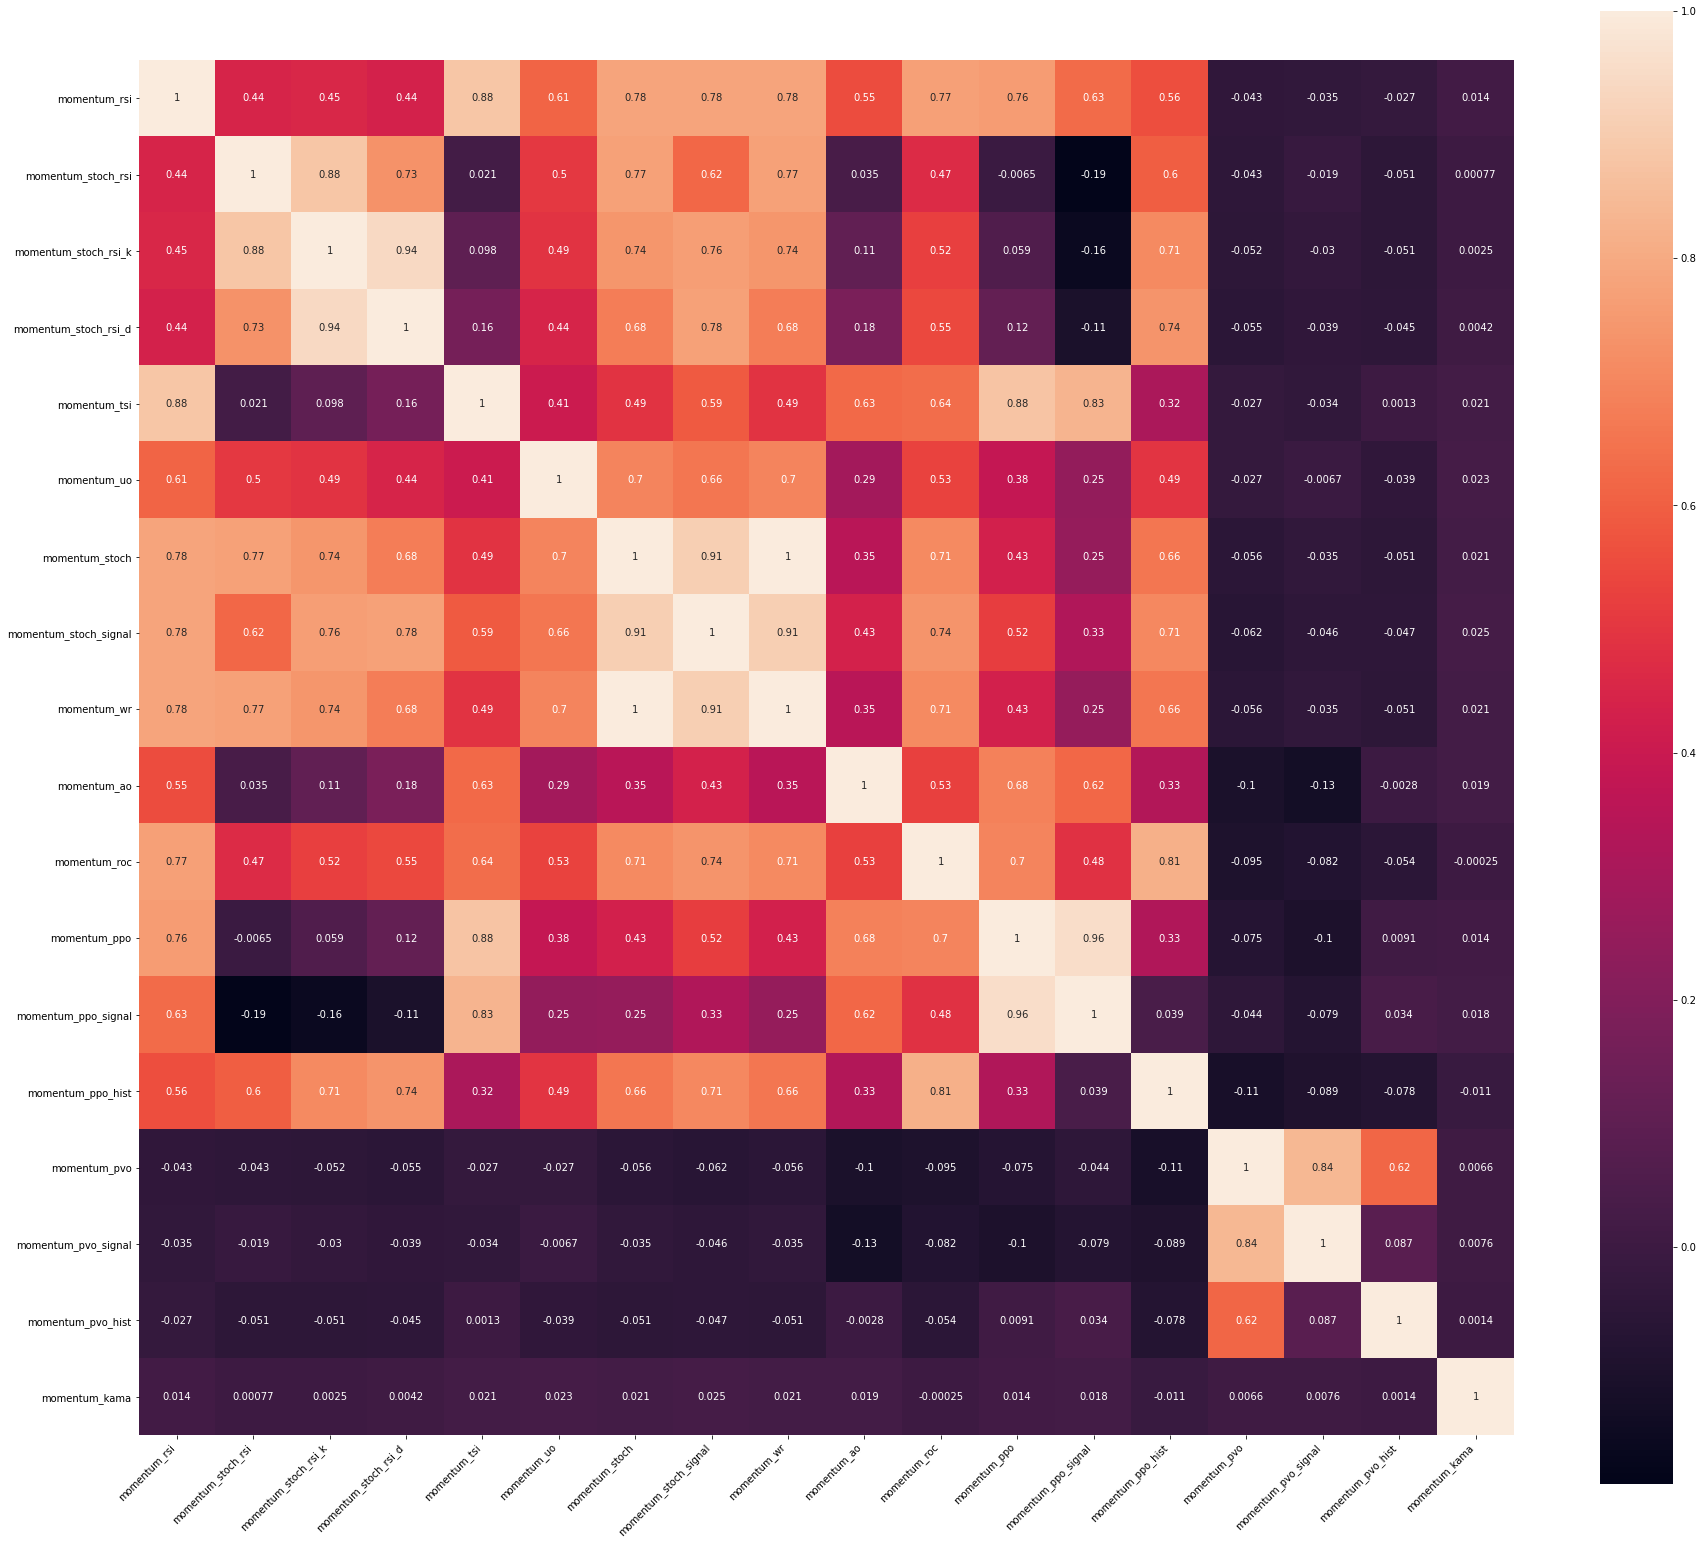

Correlation of Bollinger Bands Indicators:
3  features: Index(['bb_bbm', 'bb_bbh', 'bb_bbl'], dtype='object')


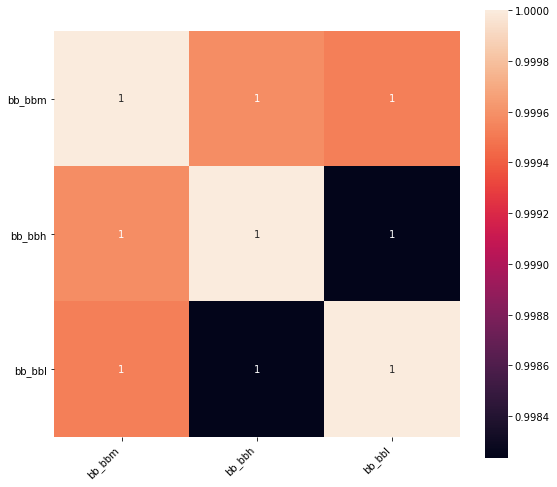

Correlation of Other Indicators:
3  features: Index(['psar', 'MACD', 'RSI'], dtype='object')


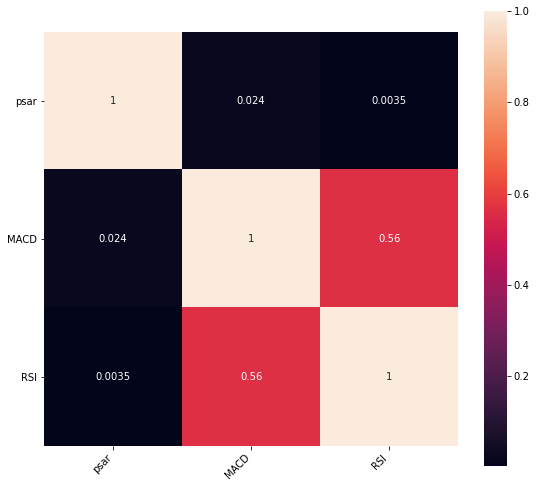

Correlation of Volume Indicators:
10  features: Index(['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi'],
      dtype='object')


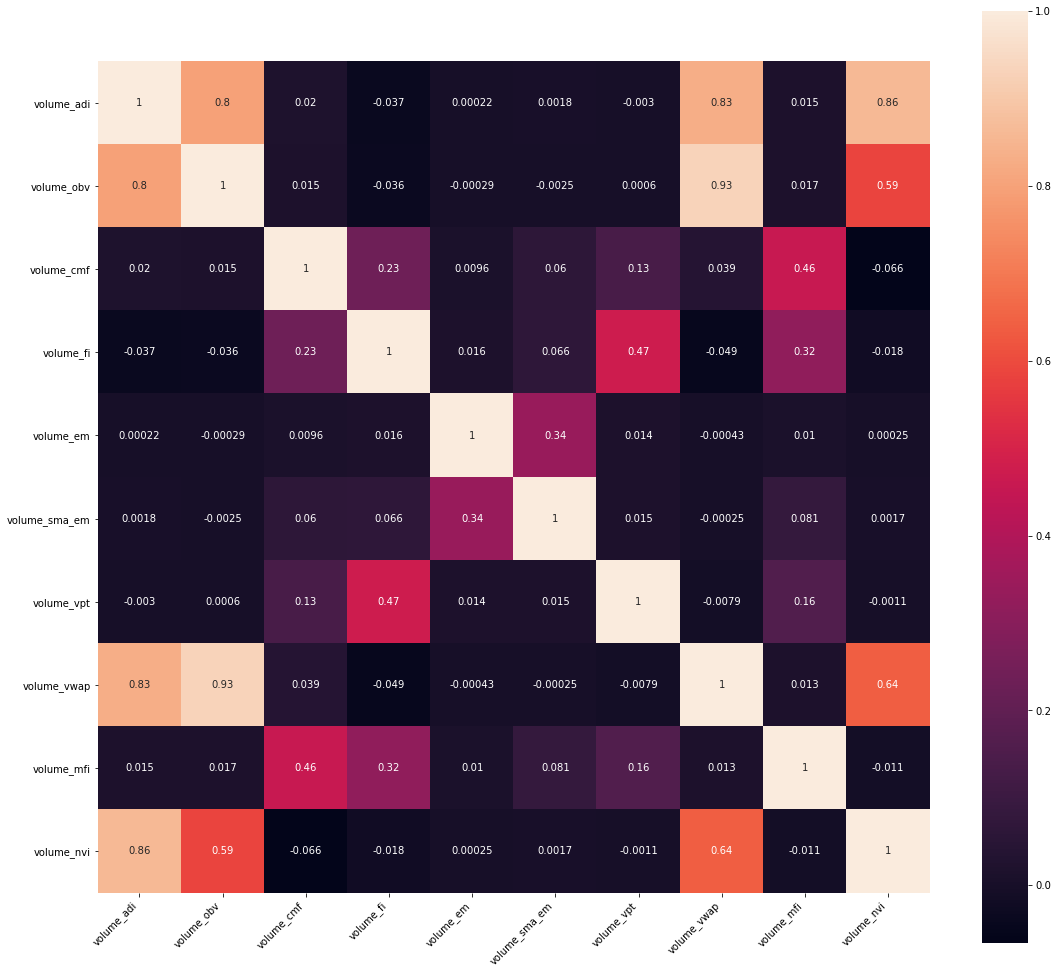

Correlation of Volatility Indicators:
21  features: Index(['volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui'],
      dtype='object')


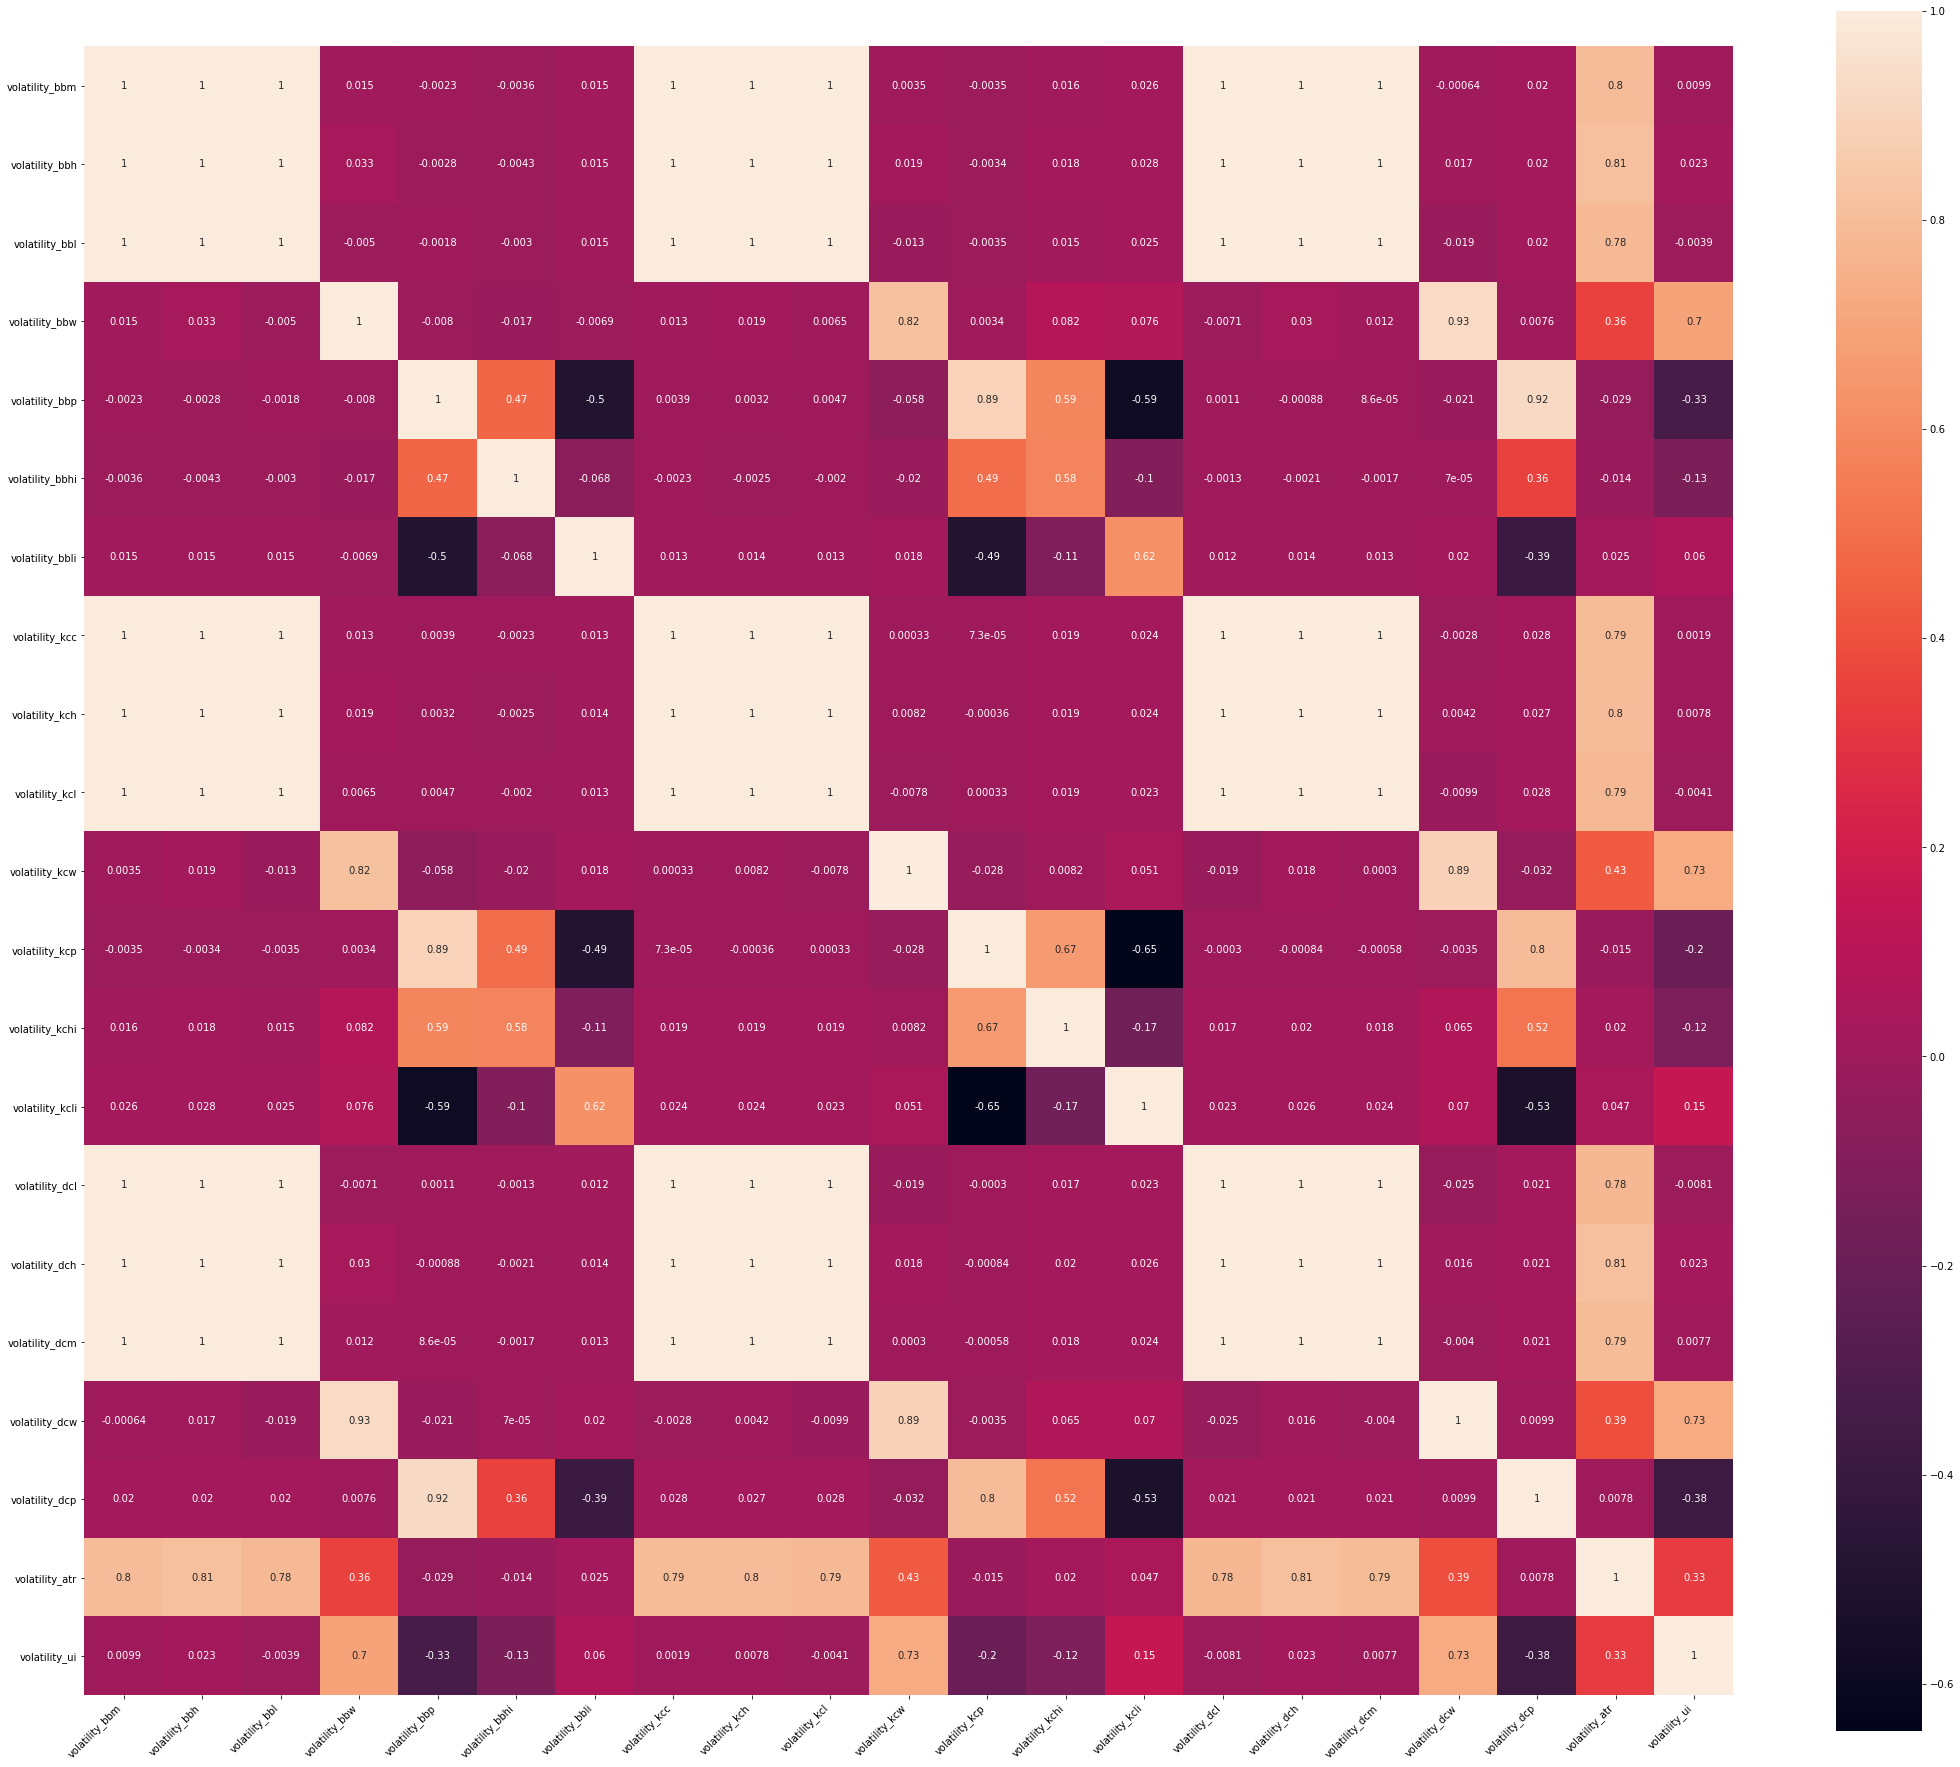

108  features: Index(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Volume USDT', 'tradecount',
       ...
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist',
       'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist',
       'momentum_kama', 'psar', 'MACD', 'RSI'],
      dtype='object', length=108)


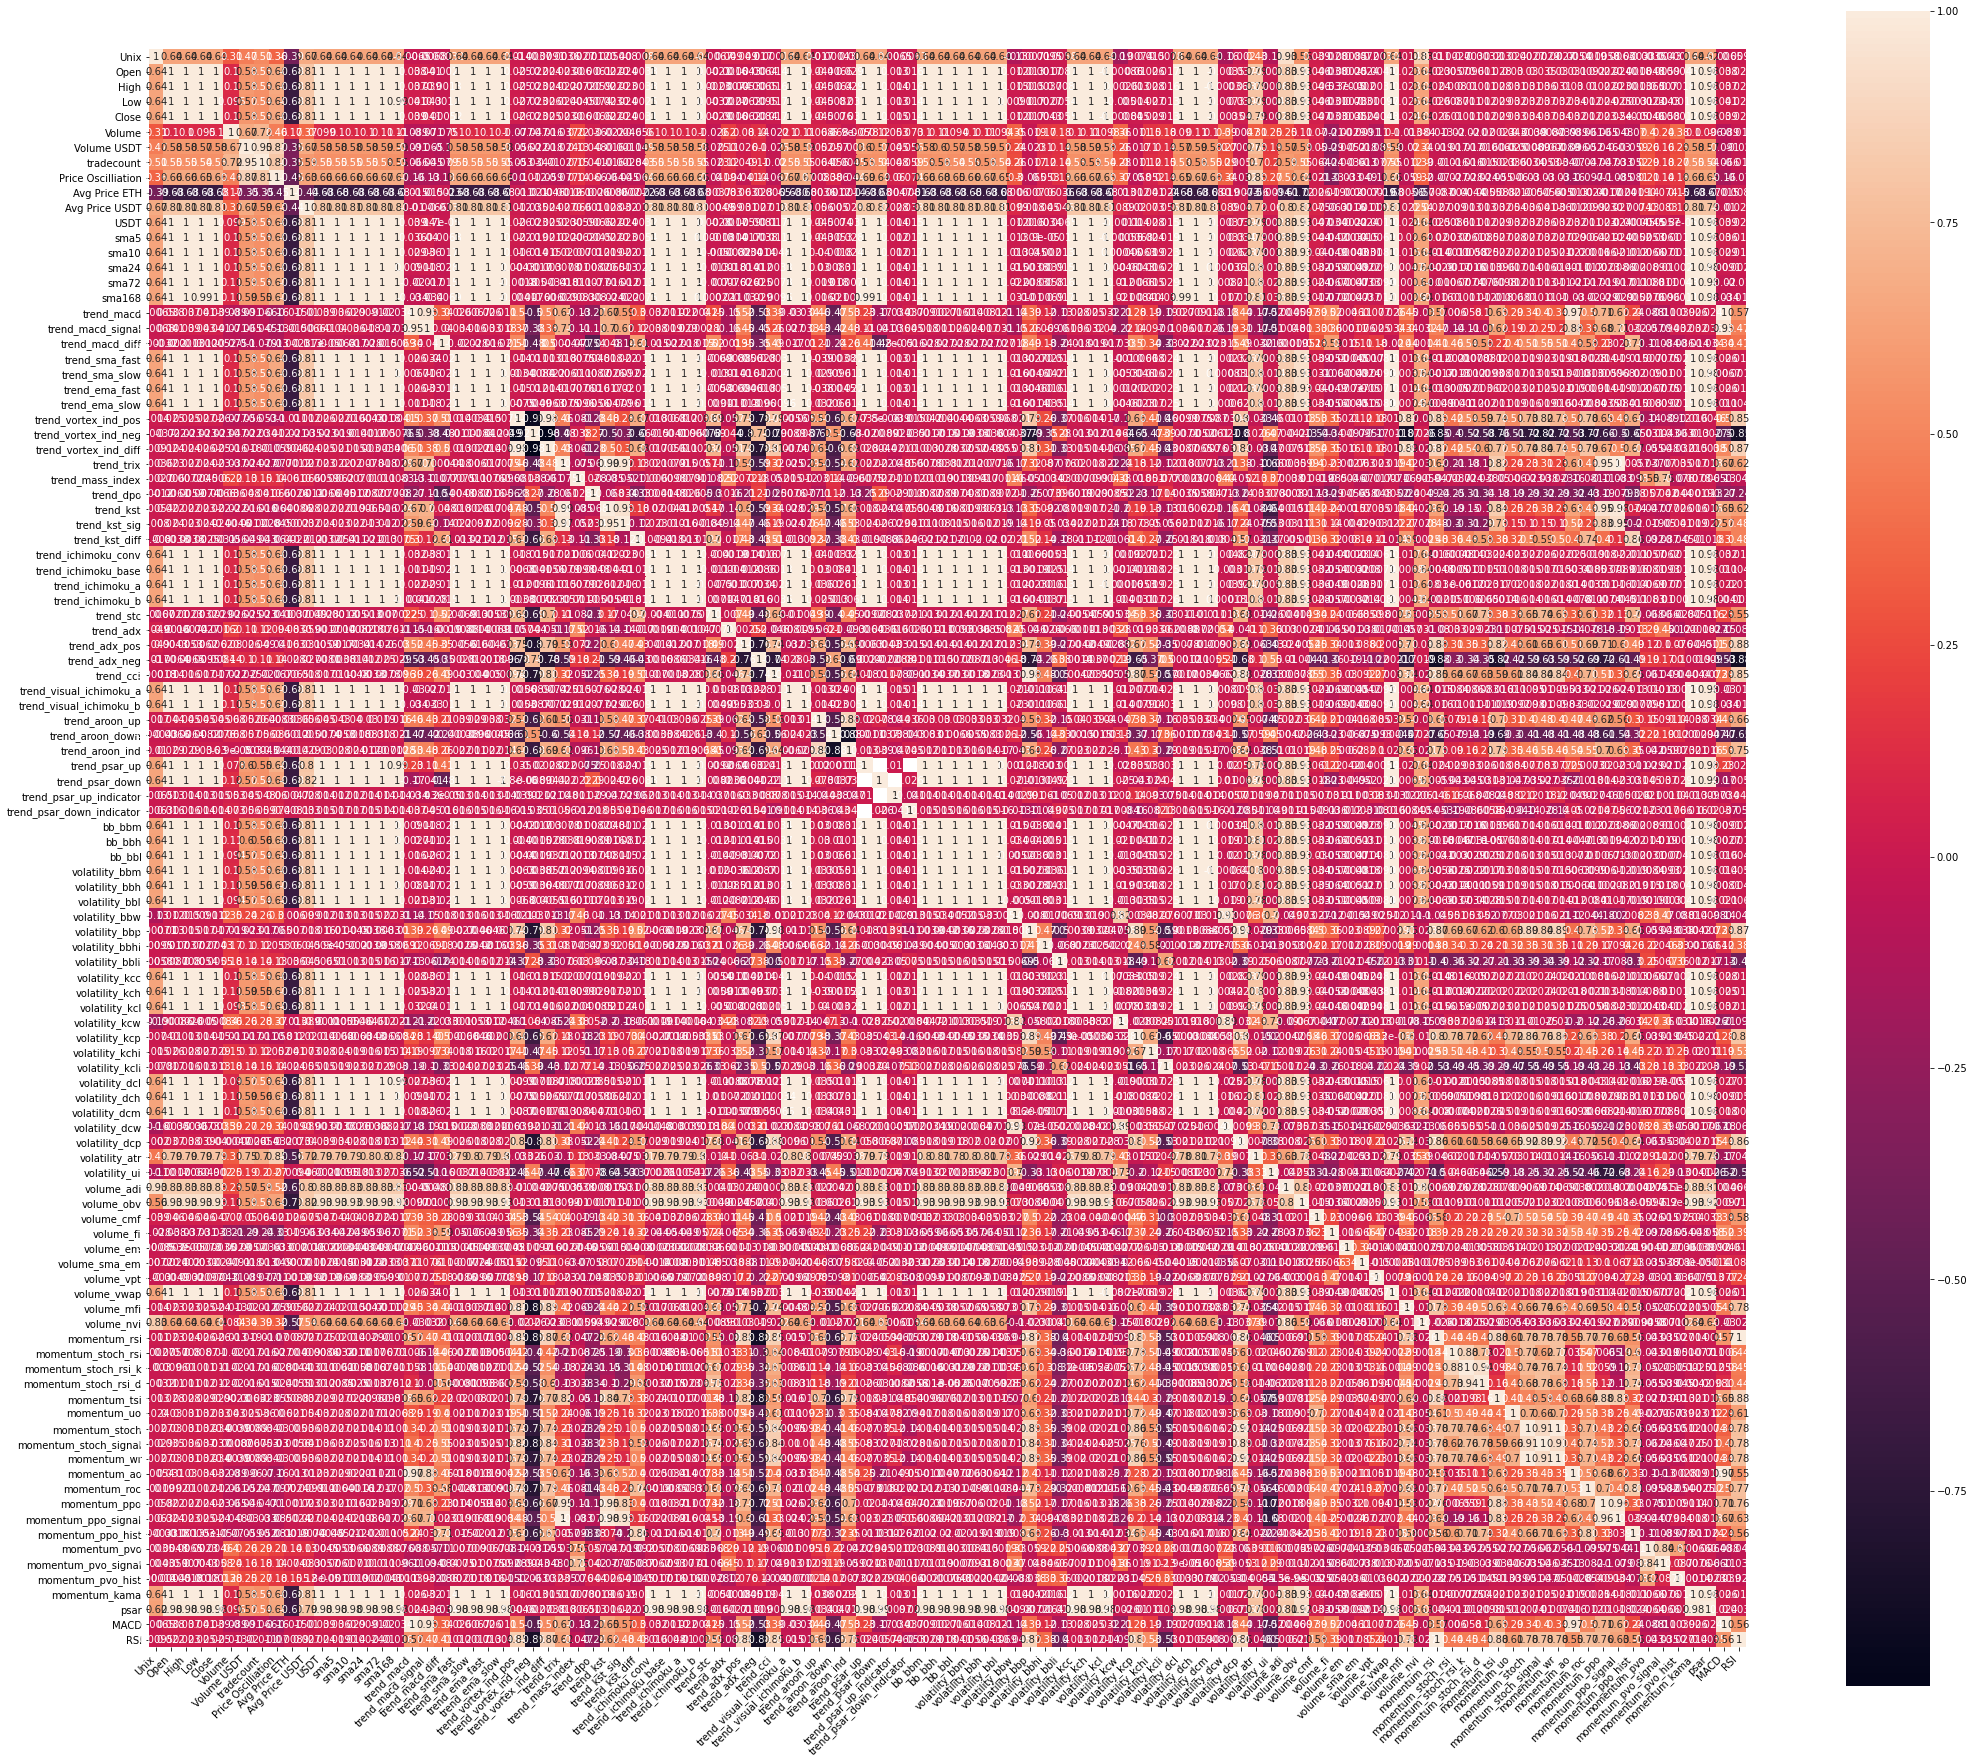

<ipython-input-9-8250c2fe252b>:136: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))


Following features are removed because of high correlation.
['tradecount', 'Price Oscilliation', 'Avg Price USDT', 'USDT', 'sma5', 'sma10', 'sma24', 'sma72', 'sma168', 'trend_macd_signal', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_diff', 'trend_trix', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up', 'trend_psar_down', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbp', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'v

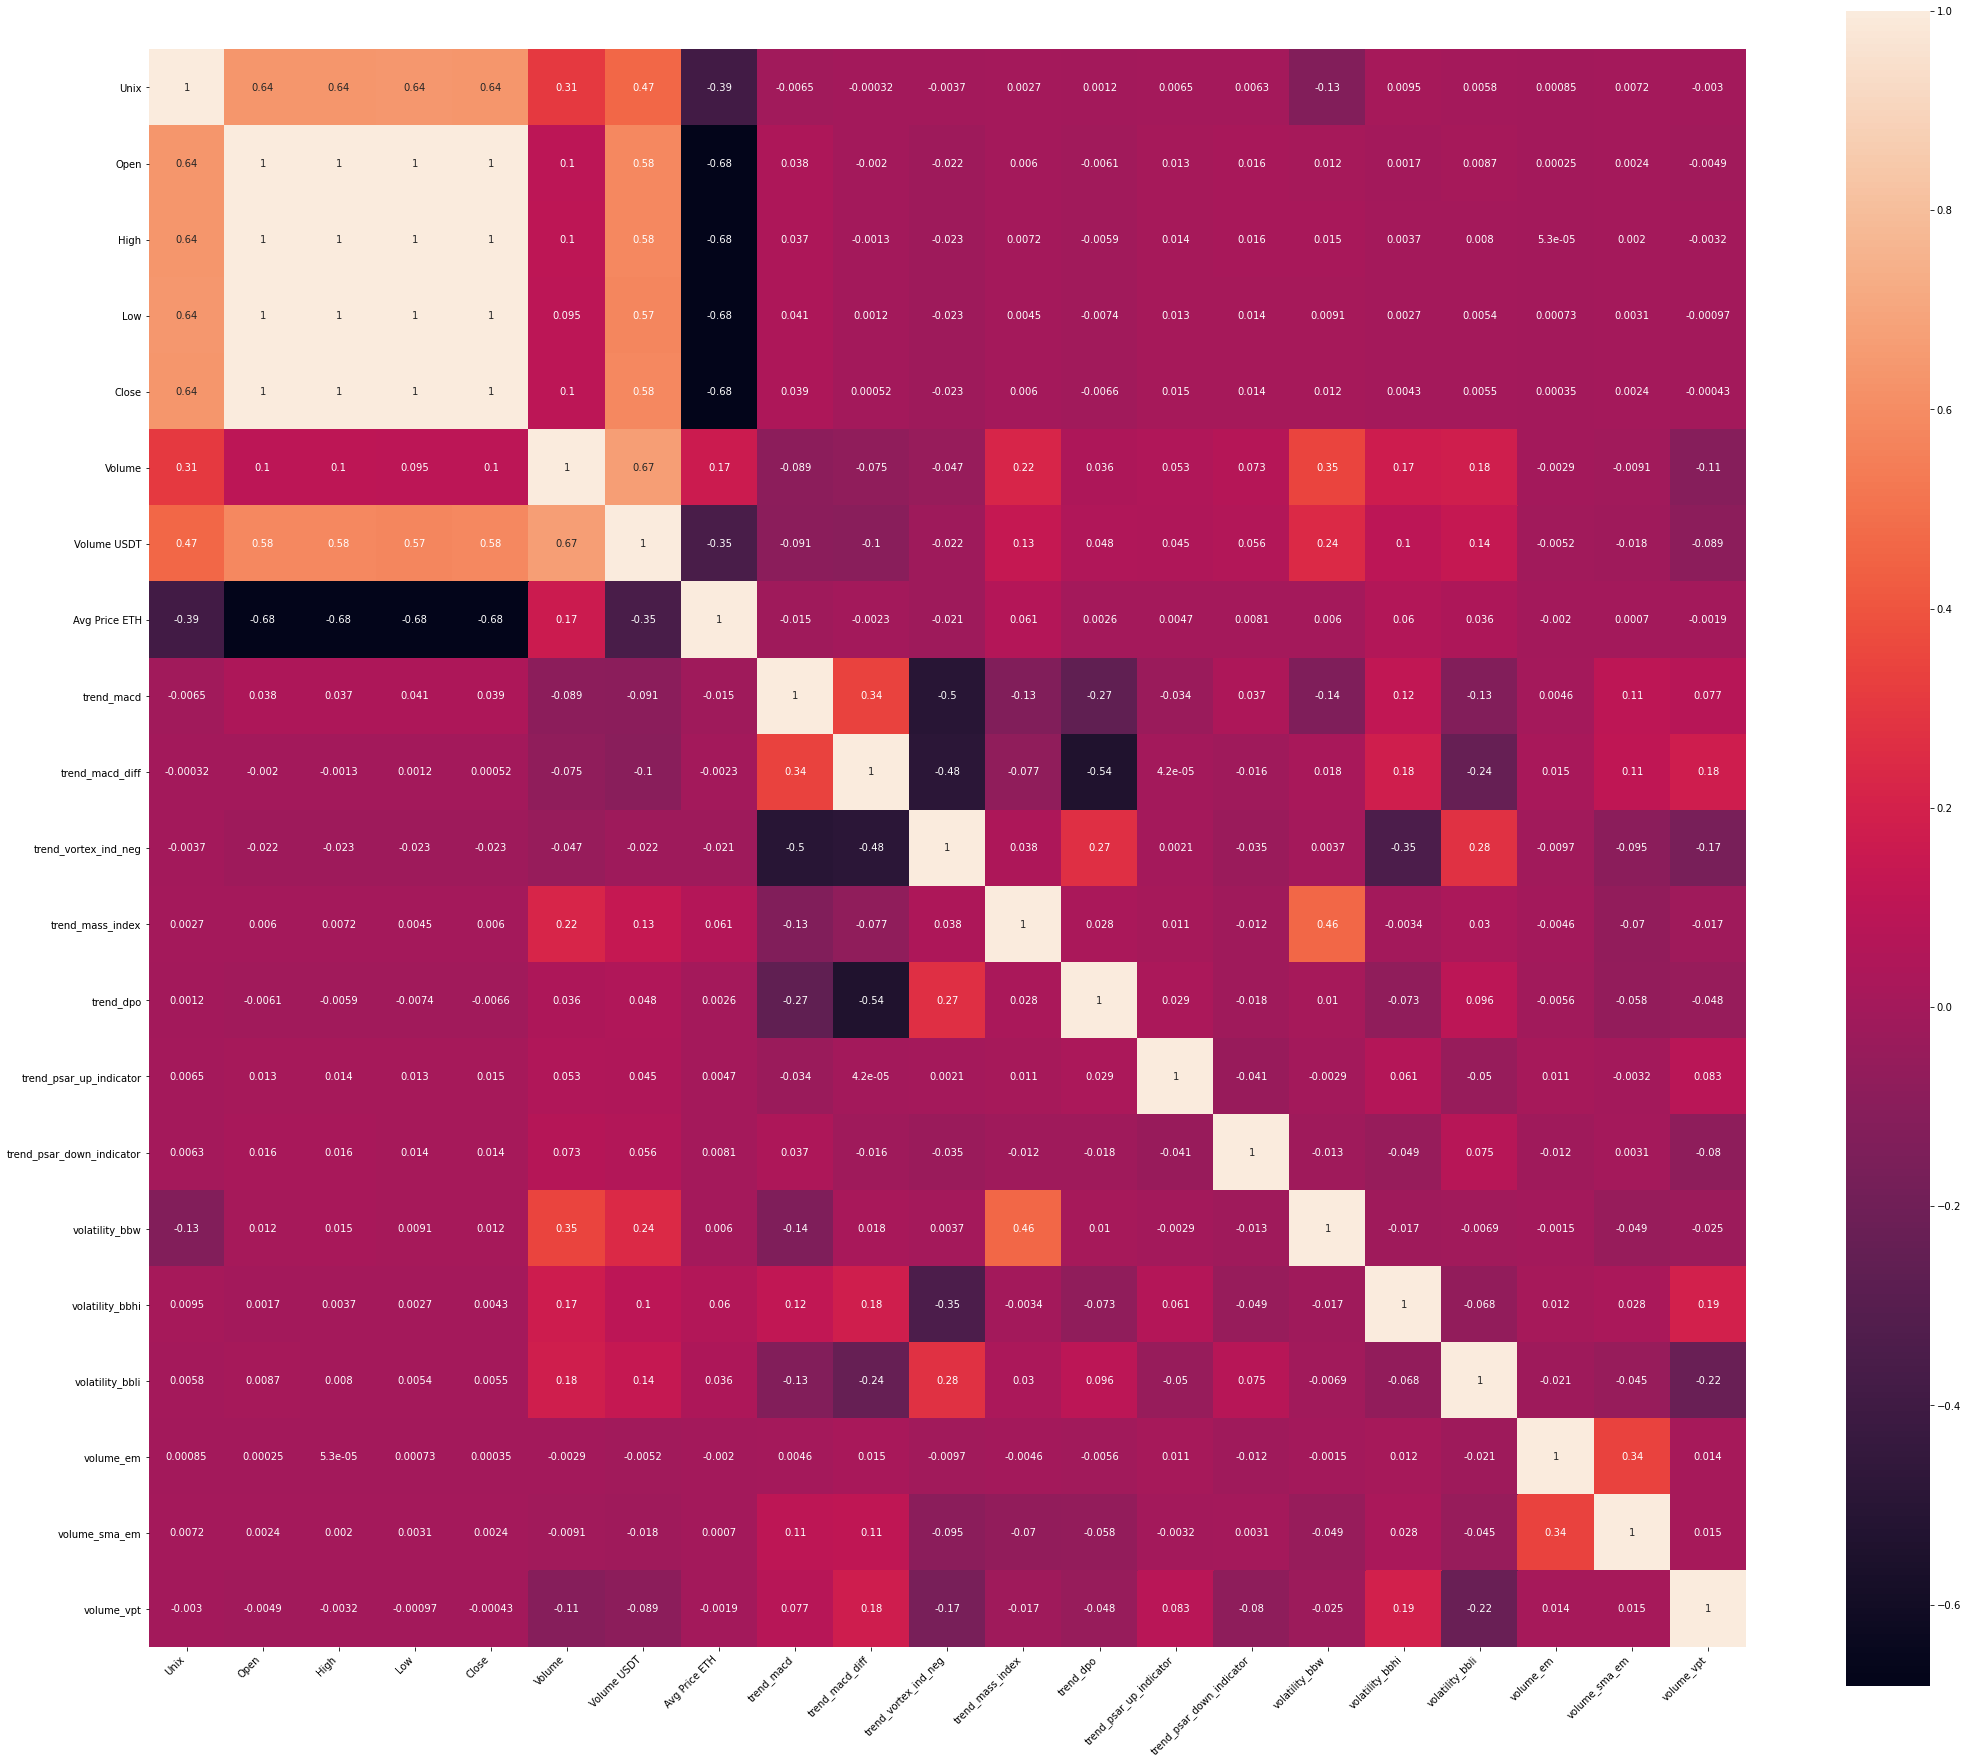

In [10]:
# print(eth_df.columns)
eth_df = eth_df.fillna(0)
eth_df_all_indicators = AddIndicators(eth_df)
# eth_df = eth_df.drop(columns=['Unix', 'Symbol'])

plot_corr(eth_df_all_indicators)

# remove NA values
# eth_df = eth_df[100:]
eth_df = DropCorrelatedFeatures(df=eth_df_all_indicators, threshold=0.5)
plot_corr(eth_df)

In [6]:

# def nomalization(df):
#     # df = df.copy()
#     column_names = df.columns.tolist()
#     print(column_names)
#     for column in column_names[1:]:
#         x = np.array(df[column]).reshape(-1,1)
#         min_max_scaler = preprocessing.MinMaxScaler()
#         x_scaled = min_max_scaler.fit_transform(x)
#         df[column] = pd.DataFrame(x_scaled)
#     return df


def Normalizing(df_original):
    df = df_original.copy()
    column_names = df.columns.tolist()
    for column in column_names[1:]:
        # Logging and Differencing
        test = np.log(df[column]) - np.log(df[column].shift(1))
        if test[1:].isnull().any():
            df[column] = df[column] - df[column].shift(1)
        else:
            df[column] = np.log(df[column]) - np.log(df[column].shift(1))
        # Min Max Scaler implemented
        Min = df[column].min()
        Max = df[column].max()
        df[column] = (df[column] - Min) / (Max - Min)

    return df


eth_df.drop(['Unix', 'Symbol'], axis=1, inplace=True)
eth_df_nomalized = Normalizing(eth_df[1000:])



/Users/apple/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
eth_df_nomalizeddf = eth_df_nomalized[1:]
eth_df = eth_df[1000+1:]

### save preprocessed dataframe to .csv file

In [8]:
eth_df.to_csv('eth_1h.csv', index=False)
eth_df_nomalizeddf.to_csv('eth_1h_normalized.csv', index=False)
print(eth_df.describe())
print(len(eth_df.columns.tolist()), eth_df.columns.tolist())
print(eth_df_nomalizeddf.describe())
print(len(eth_df_nomalizeddf.columns.tolist()), eth_df_nomalizeddf.columns.tolist())

               Open          High           Low         Close         Volume  \
count  47445.000000  47445.000000  47445.000000  47445.000000   47445.000000   
mean    1123.840132   1131.622438   1115.477728   1123.859980   24405.212255   
std     1165.661354   1173.128069   1157.613466   1165.658521   28744.570643   
min       82.160000     82.950000     81.790000     82.170000       6.519140   
25%      216.140000    217.490000    214.600000    216.120000    7845.600800   
50%      518.720000    522.960000    514.540000    518.860000   15991.522500   
75%     1693.250000   1701.260000   1683.000000   1693.260000   30331.521050   
max     4846.940000   4868.000000   4833.190000   4846.710000  493227.882820   

        Volume USDT  Avg Price ETH    trend_macd  trend_macd_diff  \
count  4.744500e+04   47445.000000  47445.000000     47445.000000   
mean   3.038701e+07       1.527465      0.171558        -0.001298   
std    5.140417e+07       0.995398     17.523522         5.255183   
min

In [9]:
depth = len(list(eth_df.columns[1:])) # OHCL + indicators without Date


### split dataset

In [10]:
lookback_window_size = 100
test_window = 720 * 6  # 6 months
    
# split training and testing datasets
train_df = eth_df[:-test_window-lookback_window_size] 
test_df = eth_df[-test_window-lookback_window_size:]

# split training and testing normalized datasets
train_df_nomalized = eth_df_nomalizeddf[:-test_window-lookback_window_size] 
test_df_nomalized = eth_df_nomalizeddf[-test_window-lookback_window_size:]

### Training

In [11]:
# # multiprocessing training/testing. Note - run from cmd or terminal
# agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size=32, model="CNN", depth=depth, comment="Normalized")
# train_multiprocessing(CustomEnv, agent, train_df, train_df_nomalized, num_worker = 32, training_batch_size=500, visualize=False, EPISODES=200000)
